In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from random import randint

from src.ca import Street, Runner
from src.rules import *


In [ ]:
def run_sim(n_lanes:int = 1,
            street_length:int = 200,
            max_timesteps:int = 1000,
            n_cars:int = 30,
            v_max:int = 8,
            dawdling_factor = 0.05,
            seed = 1227603) -> Runner:

    street = Street(n_lanes,street_length,n_cars, v_max, seed)
    if n_lanes > 1:
        rulelist = [Accelerate(v_max),
                    BreakOrTakeOver(),
                    Dawdling(dawdling_factor, seed),
                    MoveForward(),
                    MergeBack()]
    else:
        rulelist = [Accelerate(v_max),
                    BreakOrTakeOver(),
                    Dawdling(dawdling_factor, seed),
                    MoveForward()]

    runner = Runner(street, rulelist, max_timesteps = max_timesteps)
    runner.run()
    return runner

In [ ]:
r1 = run_sim(n_lanes=2, seed=1)
plt.plot(r1.metric_avg_rel_speed())

# Traffic Simulation with one lane

In [ ]:
paramspace = {"v_max": [5,8,10],                        # 3 values
              "n_cars": [10,15,20,25,30,35,40,45,50],   # 9 values
              "dawd": [0.01,0.025,0.05,0.075,0.1]}    # 5 values
# total: 135 runs

results = []
names = []
run_number = 0
names = ["run", "v_max", "n_cars", "dawdling",
         "speed_avg", "speed_std","speed_min",
         "speed_q1", "speed_median", "speed_q3",
         "speed_max", "seed"]
runs_per_experiment = 5
for v_max in paramspace["v_max"]:
    for n_cars in paramspace["n_cars"]:
        for dawdling_factor in paramspace["dawd"]:
            for n in range(runs_per_experiment):
                print(f"run number {run_number}")
                seed = randint(1000,10000000)
                r = run_sim(n_lanes=1,
                            n_cars=n_cars,
                            v_max=v_max,
                            dawdling_factor=dawdling_factor,
                            seed=seed)
                avg_speeds = r.metric_avg_rel_speed()
                results.append([run_number,
                                v_max,
                                n_cars,
                                dawdling_factor,
                                np.mean(avg_speeds),
                                np.std(avg_speeds),
                                *np.quantile(avg_speeds, [0,0.25, 0.5, 0.75,1]),
                                seed])
                run_number += 1

rdf_1lane = pd.DataFrame(results, columns=names)
rdf_1lane.to_csv("results_1lane.csv", sep=",", index=False)

In [ ]:

#warnings.filterwarnings('ignore')
g = sns.FacetGrid(rdf_1lane, row="v_max",
                  margin_titles=True, hue='dawdling')
g.map(sns.lineplot, "n_cars", 'speed_avg')


# Traffic Simulation with two lanes

In [ ]:
paramspace = {"v_max": [5,8,10],                        # 3 values
              "n_cars": [10,15,20,25,30,35,40,45,50],   # 9 values
              "dawd": [0.01,0.025,0.05,0.075,0.1]}    # 5 values
# total: 135 runs
results = []
names = []
run_number = 0
names = ["run", "v_max", "n_cars", "dawdling",
         "speed_avg", "speed_std","speed_min",
         "speed_q1", "speed_median", "speed_q3",
         "speed_max", "seed"]
runs_per_experiment = 5
for v_max in paramspace["v_max"]:
    for n_cars in paramspace["n_cars"]:
        for dawdling_factor in paramspace["dawd"]:
            for n in range(runs_per_experiment):
                print(f"run number {run_number}")
                seed = randint(1000,10000000)
                r = run_sim(n_lanes=2,
                            n_cars=n_cars,
                            v_max=v_max,
                            dawdling_factor=dawdling_factor,
                            seed=seed)
                avg_speeds = r.metric_avg_rel_speed()
                results.append([run_number,
                                v_max,
                                n_cars,
                                dawdling_factor,
                                np.mean(avg_speeds),
                                np.std(avg_speeds),
                                *np.quantile(avg_speeds, [0,0.25, 0.5, 0.75,1]),
                                seed])
                run_number += 1

rdf_2lane = pd.DataFrame(results, columns=names)
rdf_2lane.to_csv("results_2lane.csv", sep=",", index=False)

## Analysis of 1-lane experiments

In [22]:
df = pd.read_csv("results_1lane.csv", sep=",", index_col=None)
df.head()

,run,v_max,n_cars,dawdling,speed_avg,speed_std,speed_min,speed_q1,speed_median,speed_q3,speed_max,seed
0,0,5,10,0.01,0.99622,0.030785,0.34,1.0,1.0,1.0,1.0,9152750
1,1,5,10,0.01,0.99570,0.034990,0.32,1.0,1.0,1.0,1.0,4999674
2,2,5,10,0.01,0.99638,0.028328,0.36,1.0,1.0,1.0,1.0,6786429
3,3,5,10,0.01,0.99608,0.024311,0.46,1.0,1.0,1.0,1.0,5533875
4,4,5,10,0.01,0.99630,0.027120,0.42,1.0,1.0,1.0,1.0,4583010


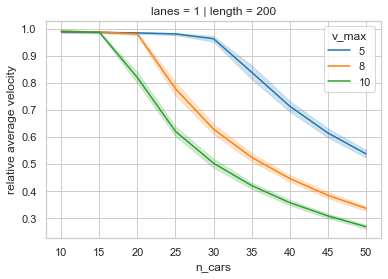

In [23]:
sns.set_theme(style="whitegrid")
ncars_1lane_len200 = sns.lineplot(data=df, x="n_cars", y="speed_avg", hue="v_max", palette="tab10")
plt.ylabel("relative average velocity")
plt.title("lanes = 1 | length = 200")
plt.savefig("figures/ncars_1lanes_len200.png")

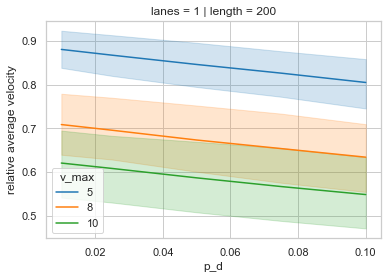

In [24]:
sns.lineplot(data=df, x="dawdling", y="speed_avg", hue="v_max", palette="tab10")
plt.xlabel("p_d")
plt.ylabel("relative average velocity")
plt.title("lanes = 1 | length = 200")
plt.savefig("figures/dawdling_1lanes_len200.png")

Interpretation:
Dawdling factor does not contribute meaningfully to the fluidity breakdown phenomenon.
As long as there is any chance for sudden speed reductions, it only takes a few occurences to influence traffic flow
if the density of traffic is enough that a jam is likely to form in the first place.

As the number of cars on the road increases however, a breakdown point where the fluidity of traffic decreases drastically is evident.

In [ ]:

paramspace = {"v_max": [5,8,10],                        # 3 values
              "n_cars": [20,25,30,35,40,45,50,55,60],   # 9 values
              "dawd": [0.05]}    # 1 values
# total: 27 runs

results = []
names = []
run_number = 0
names = ["run", "v_max", "n_cars", "dawdling",
         "speed_avg", "speed_std","speed_min",
         "speed_q1", "speed_median", "speed_q3",
         "speed_max", "seed"]
runs_per_experiment = 5
for v_max in paramspace["v_max"]:
    for n_cars in paramspace["n_cars"]:
        for dawdling_factor in paramspace["dawd"]:
            for n in range(runs_per_experiment):
                print(f"run number {run_number}")
                seed = randint(1000,10000000)
                r = run_sim(n_lanes=1,
                            street_length=400,
                            n_cars=n_cars,
                            v_max=v_max,
                            dawdling_factor=dawdling_factor,
                            seed=seed)
                avg_speeds = r.metric_avg_rel_speed()
                results.append([run_number,
                                v_max,
                                n_cars,
                                dawdling_factor,
                                np.mean(avg_speeds),
                                np.std(avg_speeds),
                                *np.quantile(avg_speeds, [0,0.25, 0.5, 0.75,1]),
                                seed])
                run_number += 1

rdf_1lane = pd.DataFrame(results, columns=names)
rdf_1lane.to_csv("results_1lane_doublelength.csv", sep=",", index=False)

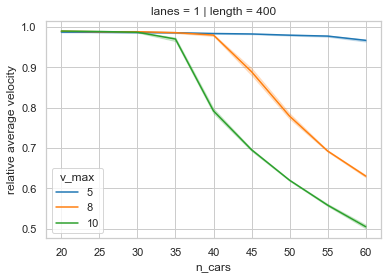

In [20]:
df = pd.read_csv("results_1lane_doublelength.csv", sep=",", index_col=None)
ncars_1lane_len400 = sns.lineplot(data=df, x="n_cars", y="speed_avg", hue="v_max", palette="tab10")
plt.ylabel("relative average velocity")
plt.title("lanes = 1 | length = 400")
plt.savefig("figures/ncars_1lanes_len400.png")

When doubling the road, approximately double the amount of cars can be accomodated before a breakdown in traffic fluidity occurs.
As a result, at a vmax of 8 40 cars can be accomdated, as opposed to 20 before.

Text(0.5, 1.0, 'Average speed for a 2-lane road of length 200')

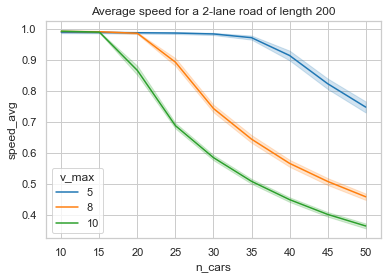

In [56]:
df = pd.read_csv("results_2lane.csv", sep=",", index_col=None)
ncars_2lanes_len200 = sns.lineplot(data=df, x="n_cars", y="speed_avg", hue="v_max", palette="tab10")
plt.title("Average speed for a 2-lane road of length 200")

adding another lane only slightly improves the breakdown behaviour. It's more noticeable in the v_max=5 scenario as the
breakdown is more spread out (the most notable "breakdown" in the curve is at n_cars=35 as oppposed to 30 for the single-lane experiment),
but the same slight shift can be observed for all experiments - but notably doubling the lanes does not double the capacity as one might expect.

It's possible that optimized overtaking and merge-back behaviour (rules) can improve this.

Text(0.5, 1.0, 'Average speed for a 2-lane road of length 200')

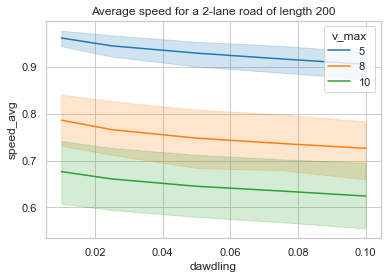

In [39]:
sns.lineplot(data=df, x="dawdling", y="speed_avg", hue="v_max", palette="tab10")
plt.title("Average speed for a 2-lane road of length 200")

Once more the dawdling factor does not show significant influence on the breakdown behaviour. It will be set to p_d = 0.05 in future experiments.

In [43]:
%%capture

paramspace = {"v_max": [5,8,10],                        # 3 values
              "n_cars": [10,15,20,25,30,35,40,45,50],   # 9 values
              "dawd": [0.05]}    # 1 values
# total: 27 runs

results = []
names = []
run_number = 0
names = ["run", "v_max", "n_cars", "dawdling",
         "speed_avg", "speed_std","speed_min",
         "speed_q1", "speed_median", "speed_q3",
         "speed_max", "seed"]
runs_per_experiment = 5
for v_max in paramspace["v_max"]:
    for n_cars in paramspace["n_cars"]:
        for dawdling_factor in paramspace["dawd"]:
            for n in range(runs_per_experiment):
                print(f"run number {run_number}")
                seed = randint(1000,10000000)
                r = run_sim(n_lanes=3,
                            street_length=200,
                            n_cars=n_cars,
                            v_max=v_max,
                            dawdling_factor=dawdling_factor,
                            seed=seed)
                avg_speeds = r.metric_avg_rel_speed()
                results.append([run_number,
                                v_max,
                                n_cars,
                                dawdling_factor,
                                np.mean(avg_speeds),
                                np.std(avg_speeds),
                                *np.quantile(avg_speeds, [0,0.25, 0.5, 0.75,1]),
                                seed])
                run_number += 1

rdf_3lane = pd.DataFrame(results, columns=names)
rdf_3lane.to_csv("results_3lane.csv", sep=",", index=False)

Text(0.5, 1.0, 'Average speed for a 3-lane road of length 200')

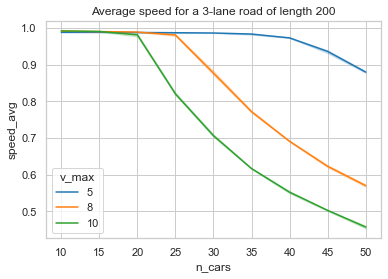

interestingly, 3 lanes shows a more marked improvement in capacity compared to 2-lane and 1-lane streets.

In [45]:
%%capture

paramspace = {"v_max": [5,8,10],                        # 3 values
              "n_cars": [10,15,20,25,30,35,40,45,50],   # 9 values
              "dawd": [0.05]}    # 1 values
# total: 27 runs

results = []
names = []
run_number = 0
names = ["run", "v_max", "n_cars", "dawdling",
         "speed_avg", "speed_std","speed_min",
         "speed_q1", "speed_median", "speed_q3",
         "speed_max", "seed"]
runs_per_experiment = 5
for v_max in paramspace["v_max"]:
    for n_cars in paramspace["n_cars"]:
        for dawdling_factor in paramspace["dawd"]:
            for n in range(runs_per_experiment):
                print(f"run number {run_number}")
                seed = randint(1000,10000000)
                r = run_sim(n_lanes=4,
                            street_length=200,
                            n_cars=n_cars,
                            v_max=v_max,
                            dawdling_factor=dawdling_factor,
                            seed=seed)
                avg_speeds = r.metric_avg_rel_speed()
                results.append([run_number,
                                v_max,
                                n_cars,
                                dawdling_factor,
                                np.mean(avg_speeds),
                                np.std(avg_speeds),
                                *np.quantile(avg_speeds, [0,0.25, 0.5, 0.75,1]),
                                seed])
                run_number += 1

rdf_4lane = pd.DataFrame(results, columns=names)
rdf_4lane.to_csv("results_4lane.csv", sep=",", index=False)

In [70]:
%%capture

paramspace = {"v_max": [5,8,10],                        # 3 values
              "n_cars": [20,25,30,35,40,45,50,55,60],   # 9 values
              "dawd": [0.05]}    # 1 values
# total: 27 runs

results = []
names = []
run_number = 0
names = ["run", "v_max", "n_cars", "dawdling",
         "speed_avg", "speed_std","speed_min",
         "speed_q1", "speed_median", "speed_q3",
         "speed_max", "seed"]
runs_per_experiment = 5
for v_max in paramspace["v_max"]:
    for n_cars in paramspace["n_cars"]:
        for dawdling_factor in paramspace["dawd"]:
            for n in range(runs_per_experiment):
                print(f"run number {run_number}")
                seed = randint(1000,10000000)
                r = run_sim(n_lanes=2,
                            street_length=400,
                            n_cars=n_cars,
                            v_max=v_max,
                            dawdling_factor=dawdling_factor,
                            seed=seed)
                avg_speeds = r.metric_avg_rel_speed()
                results.append([run_number,
                                v_max,
                                n_cars,
                                dawdling_factor,
                                np.mean(avg_speeds),
                                np.std(avg_speeds),
                                *np.quantile(avg_speeds, [0,0.25, 0.5, 0.75,1]),
                                seed])
                run_number += 1

rdf_2lane_len400 = pd.DataFrame(results, columns=names)
rdf_2lane_len400.to_csv("results_2lane_len400.csv", sep=",", index=False)

In [71]:
%%capture
paramspace = {"v_max": [5,8,10],                        # 3 values
              "n_cars": [20,25,30,35,40,45,50,55,60],   # 9 values
              "dawd": [0.05]}    # 1 values
# total: 27 runs

results = []
names = []
run_number = 0
names = ["run", "v_max", "n_cars", "dawdling",
         "speed_avg", "speed_std","speed_min",
         "speed_q1", "speed_median", "speed_q3",
         "speed_max", "seed"]
runs_per_experiment = 5
for v_max in paramspace["v_max"]:
    for n_cars in paramspace["n_cars"]:
        for dawdling_factor in paramspace["dawd"]:
            for n in range(runs_per_experiment):
                print(f"run number {run_number}")
                seed = randint(1000,10000000)
                r = run_sim(n_lanes=3,
                            street_length=400,
                            n_cars=n_cars,
                            v_max=v_max,
                            dawdling_factor=dawdling_factor,
                            seed=seed)
                avg_speeds = r.metric_avg_rel_speed()
                results.append([run_number,
                                v_max,
                                n_cars,
                                dawdling_factor,
                                np.mean(avg_speeds),
                                np.std(avg_speeds),
                                *np.quantile(avg_speeds, [0,0.25, 0.5, 0.75,1]),
                                seed])
                run_number += 1

rdf_3lane_len400 = pd.DataFrame(results, columns=names)
rdf_3lane_len400.to_csv("results_3lane_len400.csv", sep=",", index=False)

 15%|█▌        | 153/1000 [00:00<00:01, 767.82it/s]

run number 0
...............Starting simulation................


 17%|█▋        | 170/1000 [00:00<00:00, 835.08it/s]

........Ended simulation after 1000 steps!........
run number 1
...............Starting simulation................


  8%|▊         | 85/1000 [00:00<00:01, 849.81it/s]

........Ended simulation after 1000 steps!........
run number 2
...............Starting simulation................


  8%|▊         | 85/1000 [00:00<00:01, 849.82it/s]

........Ended simulation after 1000 steps!........
run number 3
...............Starting simulation................


 17%|█▋        | 168/1000 [00:00<00:01, 830.03it/s]

........Ended simulation after 1000 steps!........
run number 4
...............Starting simulation................


  8%|▊         | 76/1000 [00:00<00:01, 755.42it/s]

........Ended simulation after 1000 steps!........
run number 5
...............Starting simulation................


  8%|▊         | 79/1000 [00:00<00:01, 783.44it/s]

........Ended simulation after 1000 steps!........
run number 6
...............Starting simulation................


  7%|▋         | 66/1000 [00:00<00:01, 655.79it/s]

........Ended simulation after 1000 steps!........
run number 7
...............Starting simulation................


 16%|█▌        | 156/1000 [00:00<00:01, 772.51it/s]

........Ended simulation after 1000 steps!........
run number 8
...............Starting simulation................


  8%|▊         | 81/1000 [00:00<00:01, 803.19it/s]

........Ended simulation after 1000 steps!........
run number 9
...............Starting simulation................


  7%|▋         | 69/1000 [00:00<00:01, 685.35it/s]

........Ended simulation after 1000 steps!........
run number 10
...............Starting simulation................


  7%|▋         | 72/1000 [00:00<00:01, 712.72it/s]

........Ended simulation after 1000 steps!........
run number 11
...............Starting simulation................


  7%|▋         | 68/1000 [00:00<00:01, 673.12it/s]

........Ended simulation after 1000 steps!........
run number 12
...............Starting simulation................


  7%|▋         | 72/1000 [00:00<00:01, 713.26it/s]

........Ended simulation after 1000 steps!........
run number 13
...............Starting simulation................


  7%|▋         | 68/1000 [00:00<00:01, 679.84it/s]

........Ended simulation after 1000 steps!........
run number 14
...............Starting simulation................


  7%|▋         | 66/1000 [00:00<00:01, 653.30it/s]

........Ended simulation after 1000 steps!........
run number 15
...............Starting simulation................


  6%|▌         | 61/1000 [00:00<00:01, 609.86it/s]

........Ended simulation after 1000 steps!........
run number 16
...............Starting simulation................


  6%|▌         | 62/1000 [00:00<00:01, 619.85it/s]

........Ended simulation after 1000 steps!........
run number 17
...............Starting simulation................


  6%|▌         | 60/1000 [00:00<00:01, 593.92it/s]

........Ended simulation after 1000 steps!........
run number 18
...............Starting simulation................


  7%|▋         | 66/1000 [00:00<00:01, 659.84it/s]

........Ended simulation after 1000 steps!........
run number 19
...............Starting simulation................


  6%|▌         | 60/1000 [00:00<00:01, 599.87it/s]

........Ended simulation after 1000 steps!........
run number 20
...............Starting simulation................


 11%|█         | 112/1000 [00:00<00:01, 544.81it/s]

........Ended simulation after 1000 steps!........
run number 21
...............Starting simulation................


  6%|▌         | 59/1000 [00:00<00:01, 584.03it/s]

........Ended simulation after 1000 steps!........
run number 22
...............Starting simulation................


  6%|▌         | 60/1000 [00:00<00:01, 593.91it/s]

........Ended simulation after 1000 steps!........
run number 23
...............Starting simulation................


  6%|▌         | 55/1000 [00:00<00:01, 544.43it/s]

........Ended simulation after 1000 steps!........
run number 24
...............Starting simulation................


  6%|▌         | 56/1000 [00:00<00:01, 554.33it/s]

........Ended simulation after 1000 steps!........
run number 25
...............Starting simulation................


  5%|▌         | 52/1000 [00:00<00:01, 517.28it/s]

........Ended simulation after 1000 steps!........
run number 26
...............Starting simulation................


  6%|▌         | 56/1000 [00:00<00:01, 559.79it/s]

........Ended simulation after 1000 steps!........
run number 27
...............Starting simulation................


  5%|▌         | 54/1000 [00:00<00:01, 534.52it/s]

........Ended simulation after 1000 steps!........
run number 28
...............Starting simulation................


  6%|▌         | 58/1000 [00:00<00:01, 574.20it/s]

........Ended simulation after 1000 steps!........
run number 29
...............Starting simulation................


  5%|▌         | 53/1000 [00:00<00:01, 524.64it/s]

........Ended simulation after 1000 steps!........
run number 30
...............Starting simulation................


  5%|▌         | 52/1000 [00:00<00:01, 514.74it/s]

........Ended simulation after 1000 steps!........
run number 31
...............Starting simulation................


  5%|▌         | 51/1000 [00:00<00:01, 509.88it/s]

........Ended simulation after 1000 steps!........
run number 32
...............Starting simulation................


  5%|▌         | 51/1000 [00:00<00:01, 509.89it/s]

........Ended simulation after 1000 steps!........
run number 33
...............Starting simulation................


  5%|▌         | 51/1000 [00:00<00:01, 504.84it/s]

........Ended simulation after 1000 steps!........
run number 34
...............Starting simulation................


  9%|▉         | 94/1000 [00:00<00:01, 455.16it/s]

........Ended simulation after 1000 steps!........
run number 35
...............Starting simulation................


  5%|▍         | 47/1000 [00:00<00:02, 460.68it/s]

........Ended simulation after 1000 steps!........
run number 36
...............Starting simulation................


  4%|▍         | 45/1000 [00:00<00:02, 449.88it/s]

........Ended simulation after 1000 steps!........
run number 37
...............Starting simulation................


  5%|▍         | 48/1000 [00:00<00:01, 479.89it/s]

........Ended simulation after 1000 steps!........
run number 38
...............Starting simulation................


  4%|▍         | 45/1000 [00:00<00:02, 447.64it/s]

........Ended simulation after 1000 steps!........
run number 39
...............Starting simulation................


  4%|▍         | 45/1000 [00:00<00:02, 445.45it/s]

........Ended simulation after 1000 steps!........
run number 40
...............Starting simulation................


  4%|▍         | 42/1000 [00:00<00:02, 419.91it/s]

........Ended simulation after 1000 steps!........
run number 41
...............Starting simulation................


  4%|▍         | 45/1000 [00:00<00:02, 445.45it/s]

........Ended simulation after 1000 steps!........
run number 42
...............Starting simulation................


  5%|▍         | 46/1000 [00:00<00:02, 450.88it/s]

........Ended simulation after 1000 steps!........
run number 43
...............Starting simulation................


  4%|▍         | 42/1000 [00:00<00:02, 419.90it/s]

........Ended simulation after 1000 steps!........
run number 44
...............Starting simulation................


  8%|▊         | 83/1000 [00:00<00:01, 829.80it/s]

........Ended simulation after 1000 steps!........
run number 45
...............Starting simulation................


 15%|█▌        | 154/1000 [00:00<00:01, 771.59it/s]

........Ended simulation after 1000 steps!........
run number 46
...............Starting simulation................


  9%|▊         | 86/1000 [00:00<00:01, 859.80it/s]

........Ended simulation after 1000 steps!........
run number 47
...............Starting simulation................


 16%|█▌        | 158/1000 [00:00<00:01, 781.97it/s]

........Ended simulation after 1000 steps!........
run number 48
...............Starting simulation................


 16%|█▌        | 158/1000 [00:00<00:01, 782.00it/s]

........Ended simulation after 1000 steps!........
run number 49
...............Starting simulation................


  7%|▋         | 71/1000 [00:00<00:01, 709.65it/s]

........Ended simulation after 1000 steps!........
run number 50
...............Starting simulation................


  8%|▊         | 77/1000 [00:00<00:01, 769.82it/s]

........Ended simulation after 1000 steps!........
run number 51
...............Starting simulation................


  7%|▋         | 71/1000 [00:00<00:01, 709.84it/s]

........Ended simulation after 1000 steps!........
run number 52
...............Starting simulation................


 14%|█▍        | 145/1000 [00:00<00:01, 703.04it/s]

........Ended simulation after 1000 steps!........
run number 53
...............Starting simulation................


  7%|▋         | 74/1000 [00:00<00:01, 737.90it/s]

........Ended simulation after 1000 steps!........
run number 54
...............Starting simulation................


  7%|▋         | 69/1000 [00:00<00:01, 681.82it/s]

........Ended simulation after 1000 steps!........
run number 55
...............Starting simulation................


  7%|▋         | 67/1000 [00:00<00:01, 663.22it/s]

........Ended simulation after 1000 steps!........
run number 56
...............Starting simulation................


  7%|▋         | 68/1000 [00:00<00:01, 673.11it/s]

........Ended simulation after 1000 steps!........
run number 57
...............Starting simulation................


 13%|█▎        | 131/1000 [00:00<00:01, 655.73it/s]

........Ended simulation after 1000 steps!........
run number 58
...............Starting simulation................


  7%|▋         | 66/1000 [00:00<00:01, 659.88it/s]

........Ended simulation after 1000 steps!........
run number 59
...............Starting simulation................


  6%|▋         | 64/1000 [00:00<00:01, 633.52it/s]

........Ended simulation after 1000 steps!........
run number 60
...............Starting simulation................


  6%|▌         | 59/1000 [00:00<00:01, 584.02it/s]

........Ended simulation after 1000 steps!........
run number 61
...............Starting simulation................


  6%|▌         | 56/1000 [00:00<00:01, 559.87it/s]

........Ended simulation after 1000 steps!........
run number 62
...............Starting simulation................


  6%|▌         | 60/1000 [00:00<00:01, 593.93it/s]

........Ended simulation after 1000 steps!........
run number 63
...............Starting simulation................


  6%|▌         | 61/1000 [00:00<00:01, 603.82it/s]

........Ended simulation after 1000 steps!........
run number 64
...............Starting simulation................


  6%|▌         | 57/1000 [00:00<00:01, 564.23it/s]

........Ended simulation after 1000 steps!........
run number 65
...............Starting simulation................


 11%|█▏        | 114/1000 [00:00<00:01, 557.72it/s]

........Ended simulation after 1000 steps!........
run number 66
...............Starting simulation................


  6%|▌         | 55/1000 [00:00<00:01, 549.88it/s]

........Ended simulation after 1000 steps!........
run number 67
...............Starting simulation................


  5%|▌         | 51/1000 [00:00<00:01, 509.87it/s]

........Ended simulation after 1000 steps!........
run number 68
...............Starting simulation................


  6%|▌         | 55/1000 [00:00<00:01, 541.93it/s]

........Ended simulation after 1000 steps!........
run number 69
...............Starting simulation................


  5%|▍         | 49/1000 [00:00<00:01, 487.92it/s]

........Ended simulation after 1000 steps!........
run number 70
...............Starting simulation................


  5%|▌         | 53/1000 [00:00<00:01, 524.63it/s]

........Ended simulation after 1000 steps!........
run number 71
...............Starting simulation................


  5%|▌         | 52/1000 [00:00<00:01, 519.25it/s]

........Ended simulation after 1000 steps!........
run number 72
...............Starting simulation................


  5%|▌         | 52/1000 [00:00<00:01, 519.86it/s]

........Ended simulation after 1000 steps!........
run number 73
...............Starting simulation................


  5%|▌         | 50/1000 [00:00<00:01, 499.87it/s]

........Ended simulation after 1000 steps!........
run number 74
...............Starting simulation................


  5%|▍         | 49/1000 [00:00<00:01, 488.76it/s]

........Ended simulation after 1000 steps!........
run number 75
...............Starting simulation................


  4%|▍         | 43/1000 [00:00<00:02, 424.06it/s]

........Ended simulation after 1000 steps!........
run number 76
...............Starting simulation................


  5%|▍         | 48/1000 [00:00<00:02, 475.14it/s]

........Ended simulation after 1000 steps!........
run number 77
...............Starting simulation................


  5%|▍         | 47/1000 [00:00<00:02, 469.89it/s]

........Ended simulation after 1000 steps!........
run number 78
...............Starting simulation................


  4%|▍         | 45/1000 [00:00<00:02, 449.99it/s]

........Ended simulation after 1000 steps!........
run number 79
...............Starting simulation................


  4%|▍         | 42/1000 [00:00<00:02, 419.89it/s]

........Ended simulation after 1000 steps!........
run number 80
...............Starting simulation................


  5%|▍         | 46/1000 [00:00<00:02, 455.33it/s]

........Ended simulation after 1000 steps!........
run number 81
...............Starting simulation................


  4%|▍         | 44/1000 [00:00<00:02, 435.52it/s]

........Ended simulation after 1000 steps!........
run number 82
...............Starting simulation................


  4%|▍         | 45/1000 [00:00<00:02, 445.42it/s]

........Ended simulation after 1000 steps!........
run number 83
...............Starting simulation................


  5%|▍         | 46/1000 [00:00<00:02, 452.51it/s]

........Ended simulation after 1000 steps!........
run number 84
...............Starting simulation................


  4%|▍         | 42/1000 [00:00<00:02, 415.75it/s]

........Ended simulation after 1000 steps!........
run number 85
...............Starting simulation................


  4%|▍         | 42/1000 [00:00<00:02, 411.65it/s]

........Ended simulation after 1000 steps!........
run number 86
...............Starting simulation................


  4%|▍         | 42/1000 [00:00<00:02, 415.66it/s]

........Ended simulation after 1000 steps!........
run number 87
...............Starting simulation................


  4%|▍         | 43/1000 [00:00<00:02, 417.53it/s]

........Ended simulation after 1000 steps!........
run number 88
...............Starting simulation................


  4%|▍         | 42/1000 [00:00<00:02, 419.90it/s]

........Ended simulation after 1000 steps!........
run number 89
...............Starting simulation................


  8%|▊         | 78/1000 [00:00<00:01, 766.23it/s]

........Ended simulation after 1000 steps!........
run number 90
...............Starting simulation................


 16%|█▌        | 160/1000 [00:00<00:01, 790.50it/s]

........Ended simulation after 1000 steps!........
run number 91
...............Starting simulation................


  8%|▊         | 79/1000 [00:00<00:01, 781.97it/s]

........Ended simulation after 1000 steps!........
run number 92
...............Starting simulation................


  8%|▊         | 79/1000 [00:00<00:01, 779.71it/s]

........Ended simulation after 1000 steps!........
run number 93
...............Starting simulation................


  8%|▊         | 77/1000 [00:00<00:01, 769.78it/s]

........Ended simulation after 1000 steps!........
run number 94
...............Starting simulation................


  7%|▋         | 74/1000 [00:00<00:01, 732.43it/s]

........Ended simulation after 1000 steps!........
run number 95
...............Starting simulation................


  8%|▊         | 78/1000 [00:00<00:01, 765.44it/s]

........Ended simulation after 1000 steps!........
run number 96
...............Starting simulation................


  8%|▊         | 76/1000 [00:00<00:01, 759.79it/s]

........Ended simulation after 1000 steps!........
run number 97
...............Starting simulation................


  6%|▌         | 62/1000 [00:00<00:01, 617.32it/s]

........Ended simulation after 1000 steps!........
run number 98
...............Starting simulation................


  8%|▊         | 76/1000 [00:00<00:01, 752.26it/s]

........Ended simulation after 1000 steps!........
run number 99
...............Starting simulation................


  6%|▌         | 60/1000 [00:00<00:01, 588.76it/s]

........Ended simulation after 1000 steps!........
run number 100
...............Starting simulation................


 13%|█▎        | 132/1000 [00:00<00:01, 640.99it/s]

........Ended simulation after 1000 steps!........
run number 101
...............Starting simulation................


  7%|▋         | 66/1000 [00:00<00:01, 653.32it/s]

........Ended simulation after 1000 steps!........
run number 102
...............Starting simulation................


  6%|▋         | 64/1000 [00:00<00:01, 633.51it/s]

........Ended simulation after 1000 steps!........
run number 103
...............Starting simulation................


  6%|▌         | 62/1000 [00:00<00:01, 613.71it/s]

........Ended simulation after 1000 steps!........
run number 104
...............Starting simulation................


  6%|▌         | 62/1000 [00:00<00:01, 613.72it/s]

........Ended simulation after 1000 steps!........
run number 105
...............Starting simulation................


 12%|█▏        | 122/1000 [00:00<00:01, 600.32it/s]

........Ended simulation after 1000 steps!........
run number 106
...............Starting simulation................


  6%|▌         | 60/1000 [00:00<00:01, 588.61it/s]

........Ended simulation after 1000 steps!........
run number 107
...............Starting simulation................


 12%|█▏        | 117/1000 [00:00<00:01, 582.32it/s]

........Ended simulation after 1000 steps!........
run number 108
...............Starting simulation................


  6%|▌         | 60/1000 [00:00<00:01, 599.85it/s]

........Ended simulation after 1000 steps!........
run number 109
...............Starting simulation................


 11%|█         | 108/1000 [00:00<00:01, 535.61it/s]

........Ended simulation after 1000 steps!........
run number 110
...............Starting simulation................


  5%|▌         | 51/1000 [00:00<00:01, 509.88it/s]

........Ended simulation after 1000 steps!........
run number 111
...............Starting simulation................


  5%|▌         | 53/1000 [00:00<00:01, 529.81it/s]

........Ended simulation after 1000 steps!........
run number 112
...............Starting simulation................


  5%|▌         | 51/1000 [00:00<00:01, 504.82it/s]

........Ended simulation after 1000 steps!........
run number 113
...............Starting simulation................


 10%|▉         | 96/1000 [00:00<00:01, 473.34it/s]

........Ended simulation after 1000 steps!........
run number 114
...............Starting simulation................


  5%|▌         | 51/1000 [00:00<00:01, 503.55it/s]

........Ended simulation after 1000 steps!........
run number 115
...............Starting simulation................


  5%|▌         | 50/1000 [00:00<00:01, 497.69it/s]

........Ended simulation after 1000 steps!........
run number 116
...............Starting simulation................


 10%|▉         | 98/1000 [00:00<00:01, 481.70it/s]

........Ended simulation after 1000 steps!........
run number 117
...............Starting simulation................


  5%|▌         | 50/1000 [00:00<00:01, 494.93it/s]

........Ended simulation after 1000 steps!........
run number 118
...............Starting simulation................


  5%|▌         | 51/1000 [00:00<00:01, 504.83it/s]

........Ended simulation after 1000 steps!........
run number 119
...............Starting simulation................


  5%|▍         | 46/1000 [00:00<00:02, 459.89it/s]

........Ended simulation after 1000 steps!........
run number 120
...............Starting simulation................


  5%|▍         | 46/1000 [00:00<00:02, 459.90it/s]

........Ended simulation after 1000 steps!........
run number 121
...............Starting simulation................


  5%|▍         | 48/1000 [00:00<00:02, 465.92it/s]

........Ended simulation after 1000 steps!........
run number 122
...............Starting simulation................


  9%|▉         | 92/1000 [00:00<00:02, 453.21it/s]

........Ended simulation after 1000 steps!........
run number 123
...............Starting simulation................


  4%|▍         | 45/1000 [00:00<00:02, 449.89it/s]

........Ended simulation after 1000 steps!........
run number 124
...............Starting simulation................


  4%|▍         | 44/1000 [00:00<00:02, 435.55it/s]

........Ended simulation after 1000 steps!........
run number 125
...............Starting simulation................


  4%|▍         | 45/1000 [00:00<00:02, 441.05it/s]

........Ended simulation after 1000 steps!........
run number 126
...............Starting simulation................


  5%|▍         | 46/1000 [00:00<00:02, 455.55it/s]

........Ended simulation after 1000 steps!........
run number 127
...............Starting simulation................


  4%|▍         | 44/1000 [00:00<00:02, 435.52it/s]

........Ended simulation after 1000 steps!........
run number 128
...............Starting simulation................


  4%|▍         | 44/1000 [00:00<00:02, 435.52it/s]

........Ended simulation after 1000 steps!........
run number 129
...............Starting simulation................


  4%|▍         | 42/1000 [00:00<00:02, 415.86it/s]

........Ended simulation after 1000 steps!........
run number 130
...............Starting simulation................


  4%|▍         | 41/1000 [00:00<00:02, 405.92it/s]

........Ended simulation after 1000 steps!........
run number 131
...............Starting simulation................


  4%|▍         | 41/1000 [00:00<00:02, 409.90it/s]

........Ended simulation after 1000 steps!........
run number 132
...............Starting simulation................


  4%|▍         | 42/1000 [00:00<00:02, 415.74it/s]

........Ended simulation after 1000 steps!........
run number 133
...............Starting simulation................


  4%|▍         | 41/1000 [00:00<00:02, 401.86it/s]

........Ended simulation after 1000 steps!........
run number 134
...............Starting simulation................


100%|██████████| 1000/1000 [00:02<00:00, 391.60it/s]

........Ended simulation after 1000 steps!........


In [72]:
%%capture

paramspace = {"v_max": [5,8,10],                        # 3 values
              "n_cars": [20,25,30,35,40,45,50,55,60],   # 9 values
              "dawd": [0.05]}    # 1 values
# total: 27 runs

results = []
names = []
run_number = 0
names = ["run", "v_max", "n_cars", "dawdling",
         "speed_avg", "speed_std","speed_min",
         "speed_q1", "speed_median", "speed_q3",
         "speed_max", "seed"]
runs_per_experiment = 5
for v_max in paramspace["v_max"]:
    for n_cars in paramspace["n_cars"]:
        for dawdling_factor in paramspace["dawd"]:
            for n in range(runs_per_experiment):
                print(f"run number {run_number}")
                seed = randint(1000,10000000)
                r = run_sim(n_lanes=4,
                            street_length=400,
                            n_cars=n_cars,
                            v_max=v_max,
                            dawdling_factor=dawdling_factor,
                            seed=seed)
                avg_speeds = r.metric_avg_rel_speed()
                results.append([run_number,
                                v_max,
                                n_cars,
                                dawdling_factor,
                                np.mean(avg_speeds),
                                np.std(avg_speeds),
                                *np.quantile(avg_speeds, [0,0.25, 0.5, 0.75,1]),
                                seed])
                run_number += 1

rdf_4lane_len400 = pd.DataFrame(results, columns=names)
rdf_4lane_len400.to_csv("results_4lane_len400.csv", sep=",", index=False)

In [76]:
df_1lane_len200 = pd.read_csv("results_1lane.csv", sep=",", index_col=None)
df_1lane_len200["lanes"] = 1
df_1lane_len200["length"] = 200
df_2lanes_len200 = pd.read_csv("results_2lane.csv", sep=",", index_col=None)
df_2lanes_len200["lanes"] = 2
df_2lanes_len200["length"] = 200
df_3lanes_len200 = pd.read_csv("results_3lane.csv", sep=",", index_col=None)
df_3lanes_len200["lanes"] = 3
df_3lanes_len200["length"] = 200
df_4lanes_len200 = pd.read_csv("results_4lane.csv", sep=",", index_col=None)
df_4lanes_len200["lanes"] = 4
df_4lanes_len200["length"] = 200


df_1lane_len400 = pd.read_csv("results_1lane_doublelength.csv", sep=",", index_col=None)
df_1lane_len400["lanes"] = 1
df_1lane_len400["length"] = 400
df_2lanes_len400 = pd.read_csv("results_2lane_len400.csv", sep=",", index_col=None)
df_2lanes_len400["lanes"] = 2
df_2lanes_len400["length"] = 400
df_3lanes_len400 = pd.read_csv("results_3lane_len400.csv", sep=",", index_col=None)
df_3lanes_len400["lanes"] = 3
df_3lanes_len400["length"] = 400
df_4lanes_len400 = pd.read_csv("results_4lane_len400.csv", sep=",", index_col=None)
df_4lanes_len400["lanes"] = 4
df_4lanes_len400["length"] = 400

df = pd.concat([df_1lane_len200, df_1lane_len400,
                df_2lanes_len200, df_2lanes_len400,
                df_3lanes_len200, df_3lanes_len400,
                df_4lanes_len200, df_4lanes_len400])

df.to_csv("all_experiments.csv", sep=",", index=False)

In [ ]:
fig, axes = plt.subplots(4,1, figsize=(6,18))

ncars_1lane_len200 = sns.lineplot(data=df_1lane_len200, x="n_cars", y="speed_avg", hue="v_max", palette="tab10", ax=axes[0])
ncars_4lanes_len200 = sns.lineplot(data=df_4lanes_len200, x="n_cars", y="speed_avg", hue="v_max", palette="tab10", ax=axes[3])
ncars_3lanes_len200 = sns.lineplot(data=df_3lanes_len200, x="n_cars", y="speed_avg", hue="v_max", palette="tab10", ax=axes[2])
ncars_2lanes_len200 = sns.lineplot(data=df_2lanes_len200, x="n_cars", y="speed_avg", hue="v_max", palette="tab10", ax=axes[1])

plt.show()

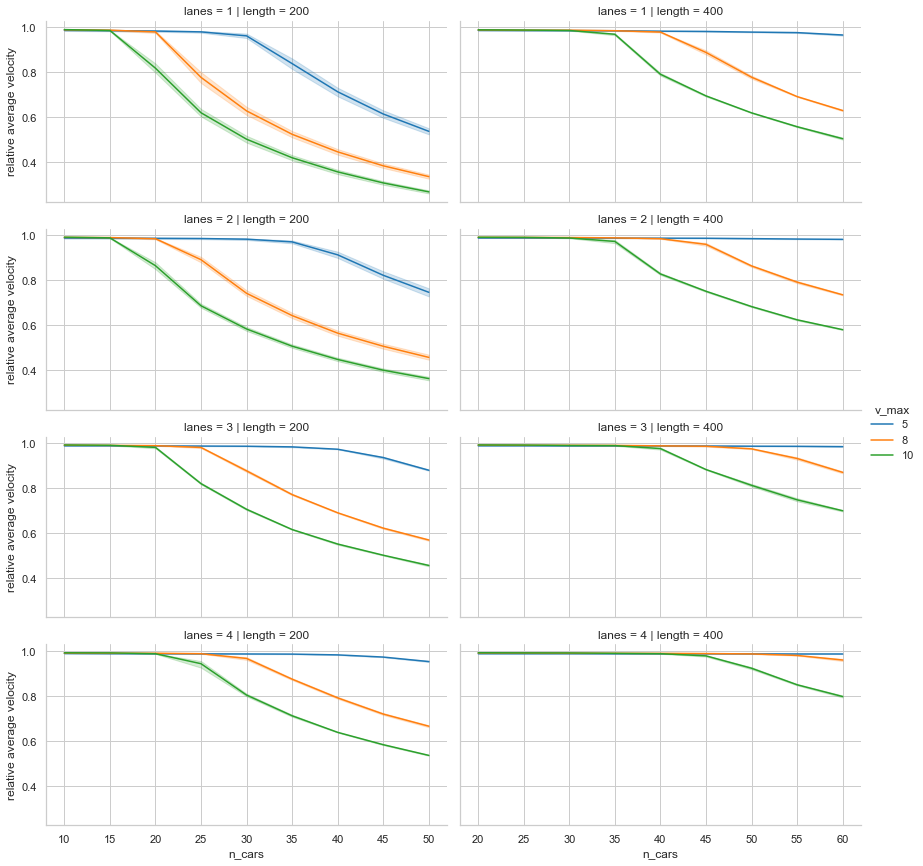

In [18]:
df = pd.read_csv("all_experiments.csv", sep=",", index_col=None)
g = sns.FacetGrid(df, col="length", row='lanes', legend_out=True, height=3, aspect=2, sharex="col")
g.map_dataframe(sns.lineplot, x='n_cars', y='speed_avg', hue='v_max', palette="tab10")
g.add_legend(title="v_max");
g.set_xlabels("n_cars")
g.set_ylabels("relative average velocity")
plt.show()
g.savefig("figures/combined.png")

In [19]:
for (lanes, length), plot in g.axes_dict.items():
    data = df[(df["lanes"] == lanes) & (df["length"] == length) & (df["dawdling"] == 0.05)]
    fig = sns.lineplot(data=data, x="n_cars", y="speed_avg", hue="v_max", palette="tab10")
    plt.title(f"lanes = {lanes} | length = {length}")
    plt.xlabel("n_cars")
    plt.ylabel("relative average velocity")
    plt.ylim(0.25, 1.05)
    plt.legend(loc="lower left", title="v_max")
    fig.get_figure().savefig(f"figures/ncars_{lanes}lanes_len{length}.png")
    plt.close()

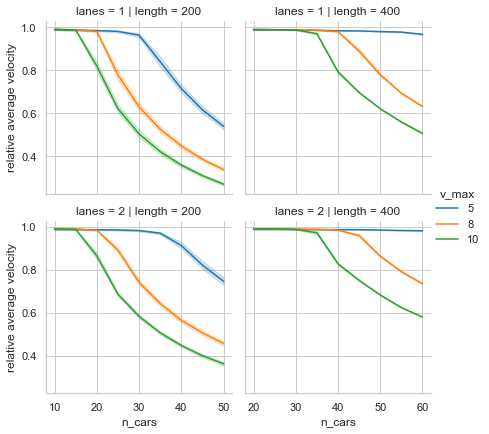

In [121]:
df2 = df[df["lanes"] <= 2]
g = sns.FacetGrid(df2, col="length", row='lanes', legend_out=True, height=3, aspect=1, sharex="col")
g.map_dataframe(sns.lineplot, x='n_cars', y='speed_avg', hue='v_max', palette="tab10")
g.add_legend(title="v_max");g.set_xlabels("n_cars")
g.set_ylabels("relative average velocity")
plt.show()
g.savefig("figures/combined2.png")

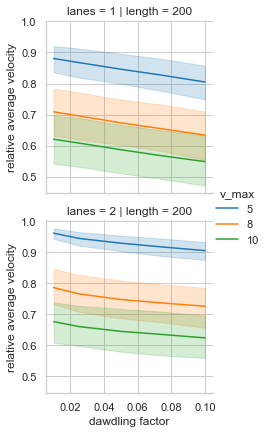

In [123]:
df3 = df[(df["lanes"] <= 2) & (df["length"] == 200)]
g = sns.FacetGrid(df3, col="length", row='lanes', legend_out=True, height=3, aspect=1, sharex="col")
g.map_dataframe(sns.lineplot, x='dawdling', y='speed_avg', hue='v_max', palette="tab10")
g.add_legend(title="v_max");
g.set_xlabels("dawdling factor")
g.set_ylabels("relative average velocity")
plt.show()
g.savefig("figures/combined3.png")